In [2]:
import sys
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split

# CONFIG

In [3]:
#
# Load config from 'config.txt'
#
def load_config():
    with open("config.txt", "r") as f:
        configtxt = f.readlines()
    configtxt = "".join(configtxt)
    return yaml.load(configtxt, Loader=yaml.FullLoader)        

def save_config(data):
    with open("config.txt", "w") as f:
        yaml.dump(data, f)

# LAG

In [4]:
def lag_time_series(serie, Pmax, remove_lag_zero=True):
    df = pd.DataFrame(serie)
    for p in range(1, Pmax + 1):
        df["P_{:d}".format(p)] = serie.shift(periods=p, fill_value=0)
    if remove_lag_zero:
        df.pop(df.columns[0])
    return df

# ONI

In [4]:
class ONI_analyzer:
    def __init__(self):
        self.ONI = pd.read_csv("data/data.csv").ONI[0:240]
    
    def run(self, Pmax):
        Popt = None
        mse_test_opt = None
        print()
        print(" P MSE_train MSE_test P_opt")
        print("----------------------------")
        for p in range(1, Pmax + 1):
            x = lag_time_series(serie=self.ONI, Pmax=p)
            y = self.ONI
            (
                x_train,
                x_test,
                y_train_real,
                y_test_real,
            ) = train_test_split(x, y, test_size=0.4, random_state=0)

            m = linear_model.LinearRegression()
            m.fit(x_train, y_train_real)

            y_train_predict = m.predict(x_train)
            y_test_predict = m.predict(x_test)
            mse_train = metrics.mean_squared_error(y_train_real, y_train_predict)
            mse_test = metrics.mean_squared_error(y_test_real, y_test_predict)
            if mse_test_opt is None or mse_test < mse_test_opt:
                Popt=p
                mse_test_opt = mse_test
            
            print("{:2d}    {:6.4f}   {:6.4f}    {:2d}".format(p, mse_train, mse_test, Popt))
            
        data = load_config()
        data['ONI']['P_OPT'] = Popt
        save_config(data)

ONI_analyzer().run(Pmax=10)


 P MSE_train MSE_test P_opt
----------------------------
 1    0.0626   0.0332     1
 2    0.0453   0.0137     2
 3    0.0442   0.0128     3
 4    0.0440   0.0140     3
 5    0.0440   0.0140     3
 6    0.0440   0.0142     3
 7    0.0440   0.0141     3
 8    0.0436   0.0152     3
 9    0.0435   0.0152     3
10    0.0435   0.0151     3


In [5]:
class ONI_simulator:
    def __init__(self):
        self.ONI = pd.read_csv("data/data.csv").ONI[0:240]
        data = load_config()
        self.P = data["ONI"]["P_OPT"]
        
    def fit(self):
        #
        # Entrena el modelo usando todos los datos historicos disponibles
        #
        x = lag_time_series(serie=self.ONI, Pmax=self.P)
        y = self.ONI
        self.m = linear_model.LinearRegression()
        self.m.fit(x, y)
        self.errors = (self.ONI - self.m.predict(x))[self.P + 1 :]
        self.errors = self.errors.tolist()

    def get_syntetic_series(self, t_base):
        y = self.ONI.copy()
        for t in range(t_base, 264):
            y[t] = self.m.intercept_
            for p in range(1, self.P + 1):
                y[t] += y[t - p] * self.m.coef_[p - 1]
            y[t] += self.errors[np.random.randint(0, len(self.errors))]
        return y
        
    def run(self):

        self.fit()
        
        CONFIG = load_config()

        for t_base in range(204, 241):

            #
            # Genera las simulaciones
            #
            simulations = {}
            for i_sim in range(CONFIG["ONI"]["NUMSIM"]):
                simulations[i_sim] = self.get_syntetic_series(t_base)

            #
            # Computa la media
            #
            means = []
            for i_sim in range(CONFIG["ONI"]["NUMSIM"]):
                means.append((i_sim, simulations[i_sim][t_base : t_base + 24].mean()))

            #
            # ordena por las medias
            #
            means = sorted(means, key=itemgetter(1))

            #
            # Percentiles
            #
            escenarios = CONFIG["ONI"]["ESCENARIOS"].copy()
            escenarios = [int(len(means) * float(e) / 100) for e in escenarios]
            escenarios = [means[e][0] for e in escenarios]

            for e, p in zip(escenarios, CONFIG["ONI"]["ESCENARIOS"].copy()):
                filename = str(t_base) + "/" + "ONI_" + str(p) + ".csv"
                simulations[e].to_csv(filename, index=False)

#ModeloONI().run()
ONI_simulator().run()

## Aportes

In [6]:
class APORTES_analyzer:
    def __init__(self):
        
        x = pd.read_csv("data/data.csv")
        self.ONI = x.ONI[0:240]
        self.Mes = x.Mes[0:240]
        self.Aportes = x.Aportes_GWh[0:240]
        self.dummies = x.loc[
            0:239, ["PRJ_0", "PRJ_1", "PRJ_2", "PRJ_3", "PRJ_4", "PRJ_5", "PRJ_6"]
        ]
    
    
    def compute_P_OPT_ONI(self, Pmax):
        #
        # Computa el orden optimo para remover el efecto del ONI
        #
        Popt = None
        mse_test_opt = None
        print()
        print(" P   MSE_train    MSE_test P_opt")
        print("---------------------------------")

        
        for p in range(0, Pmax + 1):
            x = lag_time_series(serie=self.ONI, Pmax=p, remove_lag_zero=False)
            x = pd.concat([x, self.dummies], axis=1)
            y = self.Aportes
            (
                x_train,
                x_test,
                y_train_real,
                y_test_real,
            ) = train_test_split(x, y, test_size=0.4, random_state=0)

            m = linear_model.LinearRegression()
            m.fit(x_train, y_train_real)

            y_train_predict = m.predict(x_train)
            y_test_predict = m.predict(x_test)
            mse_train = metrics.mean_squared_error(y_train_real, y_train_predict)
            mse_test = metrics.mean_squared_error(y_test_real, y_test_predict)
            
            if mse_test_opt is None or mse_test < mse_test_opt:
                Popt=p
                mse_test_opt = mse_test
            
            print("{:2d}  {:10.2f}  {:10.2f}    {:2d}".format(p, mse_train, mse_test, Popt))

        data = load_config()
        data['APORTES']['P_ONI_OPT'] = Popt
        save_config(data)

    def compute_P_OPT_APORTES(self, Pmax):

        #
        # Remueve el efecto de los aportes
        #
        P_ONI = load_config()['APORTES']['P_ONI_OPT']
        
        x = lag_time_series(serie=self.ONI, Pmax=P_ONI, remove_lag_zero=False)
        x = pd.concat([x, self.dummies], axis=1)
        m = linear_model.LinearRegression()
        m.fit(x, self.Aportes)
        aportes_sin_oni  = m.predict(x)
        
        #
        # Remueve el ciclo estacional
        #
        x = pd.concat(
            [pd.DataFrame(self.Mes), pd.DataFrame(aportes_sin_oni)], axis=1
        )
        x.columns = [x.columns[0], "aportes_sin_oni"]
        means_stds = x.groupby("Mes").agg({"aportes_sin_oni": [np.mean, np.std]})
        means_stds.columns = ["mean_mes", "std_mes"]
        aportes_sin_oni_z = [
            (v - means_stds["mean_mes"][t]) / means_stds["std_mes"][t]
            for v, t in zip(aportes_sin_oni, self.Mes)
        ]
        aportes_sin_oni_z = pd.Series(aportes_sin_oni_z)
        
        #
        # Computa el orden optimo del modelo
        #
        Popt = None
        mse_test_opt = None
        print()
        print(" P   MSE_train    MSE_test P_opt")
        print("---------------------------------")
        
        for p in range(1, Pmax + 1):
            
            #
            # Regresores
            #
            x = lag_time_series(
                serie=aportes_sin_oni_z, Pmax=p, remove_lag_zero=True
            )
            y = aportes_sin_oni_z

            #
            # Muestra de entrenamiento
            #
            (
                x_train,
                x_test,
                y_train_real,
                y_test_real,
            ) = train_test_split(x, y, test_size=0.4, random_state=0)

            #
            # Ajuste y reporte de errores
            #
            m = linear_model.LinearRegression()
            m.fit(x_train, y_train_real)

            y_train_predict = m.predict(x_train)
            y_test_predict = m.predict(x_test)
            mse_train = metrics.mean_squared_error(y_train_real, y_train_predict)
            mse_test = metrics.mean_squared_error(y_test_real, y_test_predict)
            
            if mse_test_opt is None or mse_test < mse_test_opt:
                Popt=p
                mse_test_opt = mse_test
                        
            print("{:2d}  {:10.8f}  {:10.8f}    {:2d}".format(p, mse_train, mse_test, Popt))

        data = load_config()
        data['APORTES']['P_APORTES_OPT'] = Popt
        save_config(data)



APORTES_analyzer().compute_P_OPT_ONI(Pmax=24)
APORTES_analyzer().compute_P_OPT_APORTES(Pmax=24)


 P   MSE_train    MSE_test P_opt
---------------------------------
 0  2261226.97  2774942.67     0
 1  2221607.16  2667473.87     1
 2  2205365.96  2573933.59     2
 3  2183033.98  2494339.67     3
 4  2181204.43  2528157.03     3
 5  2178677.01  2590765.58     3
 6  2132938.80  2930068.68     3
 7  2132243.78  2951808.11     3
 8  2102076.44  3091911.15     3
 9  2094539.79  3141317.64     3
10  2094521.42  3139394.23     3
11  2094398.15  3132903.59     3
12  2094381.67  3132218.46     3
13  2091951.91  3167477.12     3
14  2088159.27  3213814.89     3
15  2078758.27  3461198.15     3
16  2074942.11  3362456.66     3
17  2058899.07  3574664.67     3
18  2056844.59  3506968.64     3
19  2046412.61  3447246.90     3
20  2005740.39  3803102.66     3
21  1999098.01  3769968.13     3
22  1994140.99  3690172.56     3
23  1967838.12  3982971.69     3
24  1966525.69  4020502.47     3

 P   MSE_train    MSE_test P_opt
---------------------------------
 1  0.07441072  0.12722087     1
 2  0.

In [7]:
class APORTES_simulator:
    def __init__(self):
        x = pd.read_csv("data/data.csv")
        self.ONI = x.ONI[0:240]
        self.Mes = x.Mes[0:240]
        self.Aportes = x.Aportes_GWh[0:240]
        self.dummies = x.loc[
            0:239, ["PRJ_0", "PRJ_1", "PRJ_2", "PRJ_3", "PRJ_4", "PRJ_5", "PRJ_6"]
        ]
        
        data = load_config()
        self.P_ONI = data['APORTES']['P_ONI_OPT']
        self.P_Aportes = data['APORTES']['P_APORTES_OPT']

        
    def step_1_remove_ONI(self):
        #
        # Remueve el efecto del ONI de todos los datos
        #
        x = lag_time_series(serie=self.ONI, Pmax=self.P_ONI, remove_lag_zero=False)
        x = pd.concat([x, self.dummies], axis=1)
        y = self.Aportes
        self.modelo_oni = linear_model.LinearRegression()
        self.modelo_oni.fit(x, y)
        self.aportes_sin_oni = self.Aportes - self.modelo_oni.predict(x)

        
    def step_2_remove_seasonal_cycle(self):
        #
        x = pd.concat(
            [pd.DataFrame(self.Mes), pd.DataFrame(self.aportes_sin_oni)], axis=1
        )
        x.columns = [x.columns[0], "aportes_sin_oni"]
        self.means_stds = x.groupby("Mes").agg({"aportes_sin_oni": [np.mean, np.std]})
        self.means_stds.columns = ["mean_mes", "std_mes"]
        self.aportes_sin_oni_z = [
            (v - self.means_stds["mean_mes"][t]) / self.means_stds["std_mes"][t]
            for v, t in zip(self.aportes_sin_oni, self.Mes)
        ]
        self.aportes_sin_oni_z = pd.Series(self.aportes_sin_oni_z)
        
        
    def step_3_fit(self):
        #
        x = lag_time_series(serie=self.aportes_sin_oni_z, Pmax=self.P_Aportes)
        self.modelo_Aportes = linear_model.LinearRegression()
        self.modelo_Aportes.fit(x, self.aportes_sin_oni_z)
        self.errors = (self.aportes_sin_oni_z - self.modelo_Aportes.predict(x))[self.P_Aportes + 1 :]
        self.errors = self.errors.tolist()


    def step_4_generate_syntetic_aportes_sin_oni_z(self, t_base):
        #
        y = self.aportes_sin_oni_z.copy()

        for t in range(t_base, 264):
            y[t] = self.modelo_Aportes.intercept_
            for p in range(1, self.P_Aportes + 1):
                y[t] += y[t - p] * self.modelo_Aportes.coef_[p - 1]
            y[t] += self.errors[np.random.randint(0, len(self.errors))]
        self.sintetic_aportes_sin_oni_z = y.copy()

    def step_5_generate_syntetic_aportes_sin_oni(self):

        x = pd.DataFrame({"z": self.sintetic_aportes_sin_oni_z})
        x["Mes"] = 0
        mes = 1
        for t in range(len(x.Mes)):
            x.loc[t, "Mes"] = mes
            mes = mes + 1
            mes = mes if mes <= 12 else 1

        x["Mean"] = x.Mes.map(lambda w: self.means_stds.mean_mes[w])
        x["Std"] = x.Mes.map(lambda w: self.means_stds.std_mes[w])
        x["sintetic_aportes_sin_oni"] = self.sintetic_aportes_sin_oni_z * x.Std + x.Mean
        self.sintetic_aportes_sin_oni = x.sintetic_aportes_sin_oni
        
        
    def step_6_generate_syntetic_Aportes(self, sintetica_ONI, t_base):

        dummies = pd.DataFrame(
            1, columns=self.dummies.columns, index=range(240, 264)
        )
        dummies = pd.concat([self.dummies, dummies], axis=0)
        

        x = lag_time_series(serie=sintetica_ONI, Pmax=self.P_ONI, remove_lag_zero=False)
        
        x = pd.concat([x, dummies], axis=1)
        
        self.sintetic_Aportes = (
            self.sintetic_aportes_sin_oni + self.modelo_oni.predict(x)
        )
        

        
    def run(self):
        
        CONFIG = load_config()

        self.step_1_remove_ONI()
        self.step_2_remove_seasonal_cycle()
        self.step_3_fit()
    
        for t_base in range(204, 241):

            self.step_4_generate_syntetic_aportes_sin_oni_z(t_base)
            self.step_5_generate_syntetic_aportes_sin_oni()

            for escenario in CONFIG["ONI"]["ESCENARIOS"]:
            
                for i_serie in range(CONFIG["APORTES"]["NUMSIM"]):
            
                    filename = str(t_base) + "/" + "ONI_" + str(escenario) + ".csv"
                    sintetica_ONI = pd.read_csv(filename)['ONI']
                    self.step_6_generate_syntetic_Aportes(sintetica_ONI, t_base)
                    self.sintetic_Aportes.to_csv("{}/APORTES_{:04d}_ONI_{}.csv".format(t_base, i_serie, escenario), index=False)

APORTES_simulator().run()

## GHIDRO

In [5]:
class GHIDRO_analyzer:
    def __init__(self):
        x = pd.read_csv("data/data.csv")
        self.ONI = x.ONI[0:240]
        self.Mes = x.Mes[0:240]
        self.aportes = x.Aportes_GWh[0:240]
        self.ghidro = x.Generacion_Hidro_GWh[0:240]
        self.dummies = x.loc[
            0:239, ["PRJ_0", "PRJ_1", "PRJ_2", "PRJ_3", "PRJ_4", "PRJ_5", "PRJ_6"]
        ]


    def compute_p_optimal_explanatory(self, P_max_aportes, P_max_oni):

        P_opt_oni = None
        P_opt_aportes = None
        mse_test_opt = None
        print()
        print(" P_aportes P_oni  MSE_train    MSE_test P_opt_aportes  P_opt_oni")
        print("------------------------------------------------------------------------------------")

        for p_aportes in range(0, P_max_aportes + 1):
            for p_oni in range(0, P_max_oni + 1):

                #
                # Regresores
                #
                x_oni = lag_time_series(
                    serie=self.ONI, Pmax=p_oni, remove_lag_zero=False
                )
                x_aportes = lag_time_series(
                    serie=self.aportes, Pmax=p_aportes, remove_lag_zero=False
                )

                x = pd.concat([x_oni, x_aportes,  self.dummies], axis=1)
                y = self.ghidro

                #
                # Muestra de entrenamiento
                #
                (
                    x_train,
                    x_test,
                    y_train_real,
                    y_test_real,
                ) = train_test_split(x, y, test_size=0.4, random_state=0)

                #
                # Ajuste y reporte de errores
                #
                m = linear_model.LinearRegression()
                m.fit(x_train, y_train_real)

                y_train_predict = m.predict(x_train)
                y_test_predict = m.predict(x_test)
                mse_train = metrics.mean_squared_error(y_train_real, y_train_predict)
                mse_test = metrics.mean_squared_error(y_test_real, y_test_predict)

                if mse_test_opt is None or mse_test < mse_test_opt:
                    P_opt_aportes = p_aportes
                    P_opt_oni = p_oni
                    mse_test_opt = mse_test

                print(
                    "        {:2d}  {:2d}   {:10.2f}  {:10.2f}            {:2d}        {:2d}".format(
                        p_aportes, p_oni, mse_train, mse_test, P_opt_aportes, P_opt_oni
                    )
                )

            data = load_config()
            if "GHIDRO" not in data.keys():
                data["GHIDRO"] = {}
            data["GHIDRO"]["P_APORTES_OPT"] = P_opt_aportes
            data["GHIDRO"]["P_ONI_OPT"] = P_opt_oni
            save_config(data)


        
    def compute_p_optimal(self, Pmax):
        
        data = load_config()
        p_aportes = data["GHIDRO"]["P_APORTES_OPT"]
        p_oni = data["GHIDRO"]["P_ONI_OPT"]
        
        x_oni = lag_time_series(
            serie=self.ONI, Pmax=p_oni, remove_lag_zero=False
        )
        x_aportes = lag_time_series(
            serie=self.aportes, Pmax=p_aportes, remove_lag_zero=False
        )
        x = pd.concat([x_oni, x_aportes,  self.dummies], axis=1)
        y = self.ghidro

        #
        # Ajuste y reporte de errores
        # Modelo sin variables explicativas
        #
        m = linear_model.LinearRegression()
        m.fit(x, y)
        predict = m.predict(x)
        
        #
        # Aportes sin variables explicativas
        #
        ghidro = y - predict

        #
        # Componente autorregresiva
        # Esta parte es identica al modelo del ONI
        #
        Popt = None
        mse_test_opt = None
        print()
        print(" P MSE_train MSE_test P_opt")
        print("----------------------------")
        for p in range(1, Pmax + 1):
            x = lag_time_series(ghidro.copy(), Pmax=p, remove_lag_zero=True)
            y = ghidro.copy()
            (
                x_train,
                x_test,
                y_train_real,
                y_test_real,
            ) = train_test_split(x, y, test_size=0.4, random_state=0)

            m = linear_model.LinearRegression()
            m.fit(x_train, y_train_real)

            y_train_predict = m.predict(x_train)
            y_test_predict = m.predict(x_test)
            mse_train = metrics.mean_squared_error(y_train_real, y_train_predict)
            mse_test = metrics.mean_squared_error(y_test_real, y_test_predict)
            if mse_test_opt is None or mse_test < mse_test_opt:
                Popt=p
                mse_test_opt = mse_test
            
            print("{:2d}    {:6.4f}   {:6.4f}    {:2d}".format(p, mse_train, mse_test, Popt))
            
        data = load_config()
        data['GHIDRO']['P_OPT'] = Popt
        save_config(data)    
    
x=GHIDRO_analyzer()
x.compute_p_optimal_explanatory(P_max_aportes=15, P_max_oni=10)
x.compute_p_optimal(Pmax = 15)
#GHIDRO_analyzer().compute_p_optimal(Pmax=15)


 P_aportes P_oni  MSE_train    MSE_test P_opt_aportes  P_opt_oni
------------------------------------------------------------------------------------
         0   0     82343.14    85801.90             0         0
         0   1     78658.17    84120.09             0         1
         0   2     77270.95    84321.10             0         1
         0   3     75706.11    86425.30             0         1
         0   4     73118.16    87811.70             0         1
         0   5     70412.94    86687.09             0         1
         0   6     69437.37    79533.46             0         6
         0   7     68695.05    76011.06             0         7
         0   8     68587.94    73801.75             0         8
         0   9     68427.56    72931.74             0         9
         0  10     68412.64    72735.18             0        10
         1   0     67149.63    74196.53             0        10
         1   1     66070.70    71765.85             1         1
         1   2   

In [6]:
class GHIDRO_simulator:

    
    def run(self):
        
        data = load_config()
        p_aportes = data["GHIDRO"]["P_APORTES_OPT"]
        p_oni = data["GHIDRO"]["P_ONI_OPT"]
        
        
        x = pd.read_csv("data/data.csv")
        self.ONI = x.ONI[0:240]
        self.Mes = x.Mes[0:240]
        self.aportes = x.Aportes_GWh[0:240]
        self.ghidro = x.Generacion_Hidro_GWh[0:240]
        self.dummies = x.loc[
            0:239, ["PRJ_0", "PRJ_1", "PRJ_2", "PRJ_3", "PRJ_4", "PRJ_5", "PRJ_6"]
        ]  
        
        #
        # Remueve el efecto de las variables explicativas
        #
        x_oni = lag_time_series(
            serie=self.ONI, Pmax=p_oni, remove_lag_zero=False
        )
        x_aportes = lag_time_series(
            serie=self.aportes, Pmax=p_aportes, remove_lag_zero=False
        )

        x = pd.concat([x_oni, x_aportes, self.dummies], axis=1)
        y = self.ghidro

        #
        # Ajuste y reporte de errores
        # Modelo sin variables explicativas
        #
        m_regressors = linear_model.LinearRegression()
        m_regressors.fit(x, y)
        m_regressors_predict = m_regressors.predict(x)
        ghidro = y - m_regressors_predict

        
        # Modelo autorregresivo de la generación hidraúlica 
        # sin efectos de variables explicativas
        #
        p_opt = data['GHIDRO']['P_OPT']
        w = lag_time_series(ghidro.copy(), Pmax=p_opt, remove_lag_zero = True)
        y = ghidro.copy()
        m_ghidro = linear_model.LinearRegression()
        m_ghidro.fit(w, y)
        errors = y - m_ghidro.predict(w)
        errors = errors[p_opt:].tolist()
        
        CONFIG = load_config()
        
        dummies = pd.DataFrame(
            1, columns=self.dummies.columns, index=range(240, 264)
        )
        dummies = pd.concat([self.dummies, dummies], axis=0)
        
        for t_base in range(204, 241):

            for escenario in CONFIG["ONI"]["ESCENARIOS"]:
                
                
                for i_serie in range(CONFIG["APORTES"]["NUMSIM"]):
                    
                    #
                    # Componentes autoregresiva 
                    #
                    z = ghidro.copy()
                    
                    for t in range(t_base, 264):
                        z[t] = m_ghidro.intercept_
                        for p in range(1, p_opt + 1):
                            z[t] += z[t - p] * m_ghidro.coef_[p - 1]
                        z[t] += errors[np.random.randint(0, len(errors))]
                
                    
                    #
                    # Efecto de variables explicativas
                    #
                    filename_oni = str(t_base) + "/" + "ONI_" + str(escenario) + ".csv"
                    sintetica_ONI = pd.read_csv(filename_oni)['ONI']
                    
                    filename_aportes = "{}/APORTES_{:04d}_ONI_{}.csv".format(t_base, i_serie, escenario)
                    sintetica_aportes = pd.read_csv(filename_aportes)['sintetic_aportes_sin_oni']

                    w_oni = lag_time_series(
                        serie=sintetica_ONI, Pmax=p_oni, remove_lag_zero=False
                    )
                    w_aportes = lag_time_series(
                        serie=sintetica_aportes, Pmax=p_aportes, remove_lag_zero=False
                    )

                    w = pd.concat([w_oni, w_aportes, dummies], axis=1)
                    
                    z = z + m_regressors.predict(w)

                    
                    filename = "{}/GHIDRO_{:04d}_ONI_{}.csv".format(t_base, i_serie, escenario)
                    z.to_csv(filename, index=False)
    
GHIDRO_simulator().run()

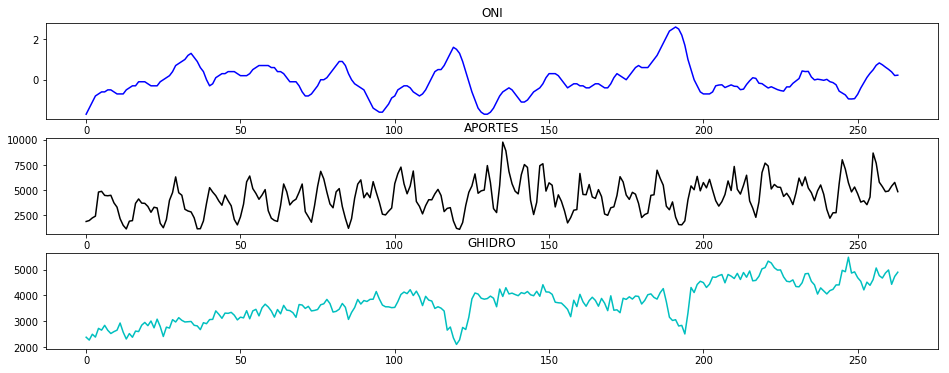

In [7]:
prueba_oni = pd.read_csv("205/ONI_10.csv")
prueba_aportes = pd.read_csv("205/APORTES_0002_ONI_10.csv")
prueba_ghidro = pd.read_csv("205/GHIDRO_0002_ONI_10.csv")

plt.figure(figsize=(16,6))
plt.subplot(311)
plt.title("ONI")
plt.plot(prueba_oni, 'b') 
plt.subplot(312)
plt.title("APORTES")
plt.plot(prueba_aportes, 'k')
plt.subplot(313)
plt.title("GHIDRO")
plt.plot(prueba_ghidro, 'c')
plt.show()

## EMBALSE

In [8]:
class EMBALSE_analyzer:
    def __init__(self):
        x = pd.read_csv("data/data.csv")
        self.ONI = x.ONI[0:240]
        self.Mes = x.Mes[0:240]
        self.aportes = x.Aportes_GWh[0:240]
        self.embalse = x.Volumen_Util_GWh[0:240]
        self.ghidro = x.Generacion_Hidro_GWh[0:240]
        self.dummies = x.loc[
            0:239, ["PRJ_0", "PRJ_1", "PRJ_2", "PRJ_3", "PRJ_4", "PRJ_5", "PRJ_6"]
        ]
        
    def normalizar_embalse(self):
        #
        x = pd.concat(
            [pd.DataFrame(self.Mes), pd.DataFrame(self.embalse)], axis=1
        )
        x.columns = [x.columns[0], "embalse"]
        self.means_stds_embalse = x.groupby("Mes").agg({"embalse": [np.mean, np.std]})
        self.means_stds_embalse.columns = ["mean_mes", "std_mes"]
        self.embalse_z = [
            (v - self.means_stds_embalse["mean_mes"][t]) / self.means_stds_embalse["std_mes"][t]
            for v, t in zip(self.embalse, self.Mes)
        ]
        self.embalse_z = pd.Series(self.embalse_z)

    def compute_p_optimal_explanatory(self, P_max_aportes, P_max_oni, P_max_ghidro):

        P_opt_oni = None
        P_opt_aportes = None
        P_opt_ghidro = None
        mse_test_opt = None
        print()
        print(" P_aportes P_oni P_ghidro MSE_train    MSE_test P_opt_aportes  P_opt_oni P_opt_ghidro")
        print("------------------------------------------------------------------------------------")

        for p_aportes in range(0, P_max_aportes + 1):
            for p_oni in range(0, P_max_oni + 1):
                for p_ghidro in range(0, P_max_ghidro + 1):
                
                    #
                    # Regresores
                    #
                    x_oni = lag_time_series(
                        serie=self.ONI, Pmax=p_oni, remove_lag_zero=False
                    )
                    x_aportes = lag_time_series(
                        serie=self.aportes, Pmax=p_aportes, remove_lag_zero=False
                    )
                    x_ghidro = lag_time_series(
                        serie=self.ghidro, Pmax=p_ghidro, remove_lag_zero=False
                    )
                    x = pd.concat([x_oni, x_aportes, x_ghidro, self.dummies], axis=1)
                    y = self.embalse_z

                    #
                    # Muestra de entrenamiento
                    #
                    (
                        x_train,
                        x_test,
                        y_train_real,
                        y_test_real,
                    ) = train_test_split(x, y, test_size=0.4, random_state=0)

                    #
                    # Ajuste y reporte de errores
                    #
                    m = linear_model.LinearRegression()
                    m.fit(x_train, y_train_real)

                    y_train_predict = m.predict(x_train)
                    y_test_predict = m.predict(x_test)
                    mse_train = metrics.mean_squared_error(y_train_real, y_train_predict)
                    mse_test = metrics.mean_squared_error(y_test_real, y_test_predict)

                    if mse_test_opt is None or mse_test < mse_test_opt:
                        P_opt_aportes = p_aportes
                        P_opt_oni = p_oni
                        P_opt_ghidro = p_ghidro
                        mse_test_opt = mse_test

                    print(
                        "        {:2d}  {:2d}  {:2d}  {:10.2f}  {:10.2f}            {:2d}   {:2d}   {:2d}".format(
                            p_aportes, p_oni, p_ghidro, mse_train, mse_test, P_opt_aportes, P_opt_oni, P_opt_ghidro
                        )
                    )

            data = load_config()
            if "EMBALSE" not in data.keys():
                data["EMBALSE"] = {}
            data["EMBALSE"]["P_APORTES_OPT"] = P_opt_aportes
            data["EMBALSE"]["P_ONI_OPT"] = P_opt_oni
            data["EMBALSE"]["P_GHIDRO_OPT"] = P_opt_ghidro
            save_config(data)


        
    def compute_p_optimal(self, Pmax):
        
        data = load_config()
        p_aportes = data["EMBALSE"]["P_APORTES_OPT"]
        p_oni = data["EMBALSE"]["P_ONI_OPT"]
        p_ghidro = data["EMBALSE"]["P_GHIDRO_OPT"]
        
        
        x_oni = lag_time_series(
            serie=self.ONI, Pmax=p_oni, remove_lag_zero=False
        )
        x_aportes = lag_time_series(
            serie=self.aportes, Pmax=p_aportes, remove_lag_zero=False
        )
        x_ghidro = lag_time_series(
            serie=self.ghidro, Pmax=p_ghidro, remove_lag_zero=False
        )
        x = pd.concat([x_oni, x_aportes, x_ghidro, self.dummies], axis=1)
        y = self.embalse_z

        #
        # Ajuste y reporte de errores
        # Modelo sin variables explicativas
        #
        m = linear_model.LinearRegression()
        m.fit(x, y)
        predict = m.predict(x)
        
        #
        # Embalse sin variables explicativas
        #
        embalse = y - predict

        #
        # Componente autorregresiva
        #
        Popt = None
        mse_test_opt = None
        print()
        print(" P MSE_train MSE_test P_opt")
        print("----------------------------")
        for p in range(1, Pmax + 1):
            x = lag_time_series(embalse.copy(), Pmax=p, remove_lag_zero=True)
            y = embalse.copy()
            (
                x_train,
                x_test,
                y_train_real,
                y_test_real,
            ) = train_test_split(x, y, test_size=0.4, random_state=0)

            m = linear_model.LinearRegression()
            m.fit(x_train, y_train_real)

            y_train_predict = m.predict(x_train)
            y_test_predict = m.predict(x_test)
            mse_train = metrics.mean_squared_error(y_train_real, y_train_predict)
            mse_test = metrics.mean_squared_error(y_test_real, y_test_predict)
            if mse_test_opt is None or mse_test < mse_test_opt:
                Popt=p
                mse_test_opt = mse_test
            
            print("{:2d}    {:6.4f}   {:6.4f}    {:2d}".format(p, mse_train, mse_test, Popt))
            
        data = load_config()
        data['EMBALSE']['P_OPT'] = Popt
        save_config(data)    
    
x=EMBALSE_analyzer()
x.normalizar_embalse()
x.compute_p_optimal_explanatory(P_max_aportes=15, P_max_oni=10, P_max_ghidro = 15 )
x.compute_p_optimal(Pmax = 15)
#GHIDRO_analyzer().compute_p_optimal(Pmax=15)


 P_aportes P_oni P_ghidro MSE_train    MSE_test P_opt_aportes  P_opt_oni P_opt_ghidro
------------------------------------------------------------------------------------
         0   0   0        0.61        0.70             0    0    0
         0   0   1        0.60        0.67             0    0    1
         0   0   2        0.60        0.67             0    0    2
         0   0   3        0.59        0.67             0    0    2
         0   0   4        0.59        0.68             0    0    2
         0   0   5        0.59        0.68             0    0    2
         0   0   6        0.58        0.72             0    0    2
         0   0   7        0.58        0.73             0    0    2
         0   0   8        0.58        0.73             0    0    2
         0   0   9        0.54        0.84             0    0    2
         0   0  10        0.53        0.81             0    0    2
         0   0  11        0.53        0.78             0    0    2
         0   0  12      

In [9]:
class EMBALSE_simulator:
    def __init__(self):
        x = pd.read_csv("data/data.csv")
        self.ONI = x.ONI[0:240]
        self.Mes = x.Mes[0:240]
        self.Aportes = x.Aportes_GWh[0:240]
        self.embalse = x.Volumen_Util_GWh[0:240]
        self.ghidro = x.Generacion_Hidro_GWh[0:240]
        self.dummies = x.loc[
            0:239, ["PRJ_0", "PRJ_1", "PRJ_2", "PRJ_3", "PRJ_4", "PRJ_5", "PRJ_6"]
        ]
        
        data = load_config()
        self.P_ONI = data['EMBALSE']['P_ONI_OPT']
        self.P_Aportes = data['EMBALSE']['P_APORTES_OPT']
        self.P_Ghidro = data['EMBALSE']['P_GHIDRO_OPT']
        self.P_Embalse = data['EMBALSE']['P_OPT']
        
    def normalizar_embalse(self):
        #
        x = pd.concat(
            [pd.DataFrame(self.Mes), pd.DataFrame(self.embalse)], axis=1
        )
        x.columns = [x.columns[0], "embalse"]
        self.means_stds_embalse = x.groupby("Mes").agg({"embalse": [np.mean, np.std]})
        self.means_stds_embalse.columns = ["mean_mes", "std_mes"]
        self.embalse_z = [
            (v - self.means_stds_embalse["mean_mes"][t]) / self.means_stds_embalse["std_mes"][t]
            for v, t in zip(self.embalse, self.Mes)
        ]
        self.embalse_z = pd.Series(self.embalse_z)

        
    def step_1_remove_ONI_Aportes(self):
        #
        # Remueve el efecto del ONI y aportes de todos los datos
        #
        # Regresores
                
        x_oni = lag_time_series(
            serie=self.ONI, Pmax=self.P_ONI, remove_lag_zero=False
        )
        x_aportes = lag_time_series(
            serie=self.Aportes, Pmax=self.P_Aportes, remove_lag_zero=False
        )
        x_ghidro = lag_time_series(
            serie=self.ghidro, Pmax=self.P_Ghidro, remove_lag_zero=False
        )

        x = pd.concat([x_oni, x_aportes, x_ghidro, self.dummies], axis=1)
        
        y = self.embalse_z

        self.modelo_explicativas = linear_model.LinearRegression()
        self.modelo_explicativas.fit(x, y)
        self.embalse_z_sin_explicativas = self.embalse_z - self.modelo_explicativas.predict(x)
        
    def step_2_fit(self):
        #
        x = lag_time_series(serie=self.embalse_z_sin_explicativas, Pmax=self.P_Embalse, remove_lag_zero = True)
        self.modelo_Embalse = linear_model.LinearRegression()
        self.modelo_Embalse.fit(x, self.embalse_z_sin_explicativas)
        self.errors = (self.embalse_z_sin_explicativas - self.modelo_Embalse.predict(x))[self.P_Embalse + 1 :]
        self.errors = self.errors.tolist()


    def step_3_generate_syntetic_embalse_z_sin_explicativas(self, t_base):
        #
        y = self.embalse_z_sin_explicativas.copy()

        for t in range(t_base, 264):
            y[t] = self.modelo_Embalse.intercept_
            for p in range(1, self.P_Embalse + 1):
                y[t] += y[t - p] * self.modelo_Embalse.coef_[p - 1]
            y[t] += self.errors[np.random.randint(0, len(self.errors))]
        self.syntetic_embalse_z_sin_explicativas = y.copy()
    
    def step_4_generate_syntetic_embalse_z(self, sintetica_ONI, sintetica_Aportes, sintetica_ghidro, t_base):

        dummies = pd.DataFrame(
            1, columns=self.dummies.columns, index=range(240, 264)
        )
        dummies = pd.concat([self.dummies, dummies], axis=0)
        

        x_oni = lag_time_series(serie=sintetica_ONI, Pmax=self.P_ONI, remove_lag_zero=False)
        x_aportes = lag_time_series(serie=sintetica_Aportes, Pmax=self.P_Aportes, remove_lag_zero=False)
        x_ghidro = lag_time_series(serie=sintetica_ghidro, Pmax=self.P_Ghidro, remove_lag_zero=False)
        x = pd.concat([x_oni, x_aportes, x_ghidro, dummies], axis=1)
        
        self.syntetic_embalse_z = (
            self.syntetic_embalse_z_sin_explicativas + self.modelo_explicativas.predict(x)
        )

    def step_5_generate_syntetic_embalse(self):

        x = pd.DataFrame({"z": self.syntetic_embalse_z})
        x["Mes"] = 0
        mes = 1
        for t in range(len(x.Mes)):
            x.loc[t, "Mes"] = mes
            mes = mes + 1
            mes = mes if mes <= 12 else 1

        x["Mean"] = x.Mes.map(lambda w: self.means_stds_embalse.mean_mes[w])
        x["Std"] = x.Mes.map(lambda w: self.means_stds_embalse.std_mes[w])
        x["syntetic_embalse"] = self.syntetic_embalse_z * x.Std + x.Mean
        self.syntetic_embalse = x.syntetic_embalse
        
    def run(self):
        
        CONFIG = load_config()

        self.step_1_remove_ONI_Aportes()
        self.step_2_fit()
    
        for t_base in range(204, 241):

         
            for escenario in CONFIG["ONI"]["ESCENARIOS"]:
            
                for i_serie in range(CONFIG["APORTES"]["NUMSIM"]):
             
                    filename_oni = str(t_base) + "/" + "ONI_" + str(escenario) + ".csv"
                    sintetica_ONI = pd.read_csv(filename_oni)['ONI']
                    filename_aportes = "{}/APORTES_{:04d}_ONI_{}.csv".format(t_base, i_serie, escenario)
                    sintetica_aportes = pd.read_csv(filename_aportes)['sintetic_aportes_sin_oni']
                    filename_ghidro = "{}/GHIDRO_{:04d}_ONI_{}.csv".format(t_base, i_serie, escenario)
                    sintetica_ghidro = pd.read_csv(filename_ghidro)['Generacion_Hidro_GWh']
                    self.step_3_generate_syntetic_embalse_z_sin_explicativas(t_base)
                    self.step_4_generate_syntetic_embalse_z(sintetica_ONI, sintetica_aportes, sintetica_ghidro, t_base)
                    self.step_5_generate_syntetic_embalse()
                    self.syntetic_embalse.to_csv("{}/EMBALSE_{:04d}_ONI_{}.csv".format(t_base, i_serie, escenario), index=False)
                    
x = EMBALSE_simulator()
x.normalizar_embalse()
x.run()

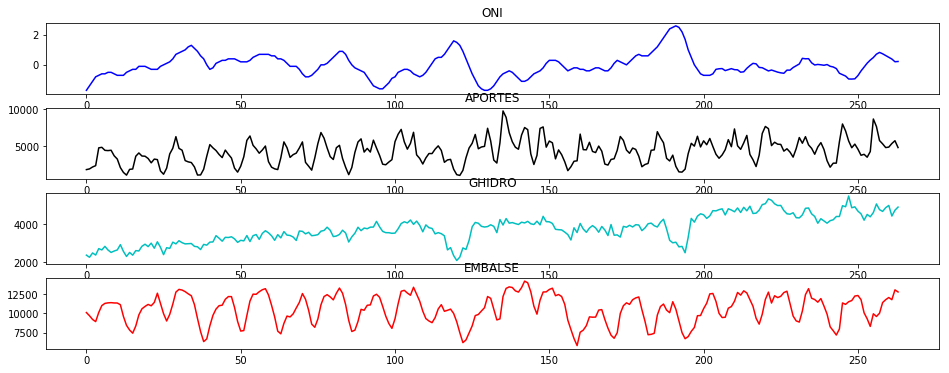

In [10]:
prueba_oni = pd.read_csv("205/ONI_10.csv")
prueba_aportes = pd.read_csv("205/APORTES_0002_ONI_10.csv")
prueba_ghidro = pd.read_csv("205/GHIDRO_0002_ONI_10.csv")
prueba_embalse = pd.read_csv("205/EMBALSE_0002_ONI_10.csv")

plt.figure(figsize=(16,6))
plt.subplot(411)
plt.title("ONI")
plt.plot(prueba_oni, 'b') 
plt.subplot(412)
plt.title("APORTES")
plt.plot(prueba_aportes, 'k')
plt.subplot(413)
plt.title("GHIDRO")
plt.plot(prueba_ghidro, 'c')
plt.subplot(414)
plt.title("EMBALSE")
plt.plot(prueba_embalse, 'r')
plt.show()

## Escenarios demanda

In [2]:
def generar_escenarios_demanda():
    def generar_escenario(t_base, factores):

        FMESES = [
            0.08158999,
            0.07753591,
            0.08409445,
            0.08116052,
            0.08459621,
            0.08150497,
            0.08469948,
            0.08583286,
            0.08392501,
            0.08573493,
            0.08348462,
            0.08584105,
        ]
        FECHAS = [
        "{:d}-{:02d}".format(ano, mes + 1) for ano in range(2000, 2023) for mes in range(12)
        ]
        
        df = pd.DataFrame({"fecha": FECHAS})
        data = pd.read_csv("data/data.csv")
        
        num_escenarios = int(len(factores) / 3)
        for i_escenario in range(num_escenarios):

            f0 = factores[i_escenario * 3]
            f1 = factores[i_escenario * 3 + 1]
            f2 = factores[i_escenario * 3 + 2]
            ts = data.Demanda_GWh.copy()

            ano_actual = data.Ano[t_base]
            ano_anterior = ano_actual - 1
            dem_anual_anterior = sum(data.Demanda_GWh[data.Ano == ano_anterior])
            dem_anual_actual = dem_anual_anterior * (1 + f0 / 100)
            mes_actual = data.Mes[t_base]
            dem_mes_real = data.Demanda_GWh[data.Ano == ano_actual]
            dem_mes_real = dem_mes_real[0:mes_actual]
            suma_dem_mes_real = sum(dem_mes_real)

            dem_mes_pry = [dem_anual_actual * f for f in FMESES]

            dem_mes_pry = dem_mes_pry[0:mes_actual]
            suma_dem_mes_pry = sum(dem_mes_pry)
            dem_anual_actual = dem_anual_actual * suma_dem_mes_real / suma_dem_mes_pry
            dem_anual_sig_1 = dem_anual_actual * (1 + f1 / 100)
            dem_anual_sig_2 = dem_anual_sig_1 * (1 + f2 / 100)

            dem_mes_pry = [dem_anual_actual * x for x in FMESES]
            dem_mes_sig_1 = [dem_anual_sig_1 * x for x in FMESES]
            dem_mes_sig_2 = [dem_anual_sig_2 * x for x in FMESES]

            dem_mes = dem_mes_pry + dem_mes_sig_1 + dem_mes_sig_2
            dem_mes = dem_mes[mes_actual - 1 : mes_actual + 23]
            ts[t_base : t_base + 24] = dem_mes
            #ts[t_base + 12 : t_base + 36] = dem_mes

            df["esc-{:d}".format(i_escenario)] = ts


        return df

    data = pd.read_csv("data/data.csv")

    data_escenarios = pd.read_csv("data/esc-dem-agente.csv")
    for t_base in range(204, 205):
        num_escenarios = int((len(data_escenarios.columns) - 1) / 3) - 1
        cols_escenarios = [
            1 + i * 3 + j for i in range(num_escenarios) for j in range(3)
        ]
        factores = data_escenarios.loc[t_base, data_escenarios.columns[cols_escenarios]]
        filename =  str(t_base)
        generar_escenario(t_base, factores).to_csv(
            filename + "/series-esc-dem-agente.csv", index=False
        )

    data_escenarios = pd.read_csv("data/esc-dem-operador.csv")
    for t_base in range(204, 205):
        factores = data_escenarios.loc[t_base, data_escenarios.columns[[1, 2, 3]]]
        filename =  str(t_base)
        generar_escenario(t_base, factores).to_csv(
            filename + "/series-esc-dem-operador.csv", index=False
        )


generar_escenarios_demanda()

In [10]:
def generar_escenarios_demanda():
    def generar_escenario(t_base, factores):

        FMESES = [
            0.08158999,
            0.07753591,
            0.08409445,
            0.08116052,
            0.08459621,
            0.08150497,
            0.08469948,
            0.08583286,
            0.08392501,
            0.08573493,
            0.08348462,
            0.08584105,
        ]
        FECHAS = [
        "{:d}-{:02d}".format(ano, mes + 1) for ano in range(2000, 2023) for mes in range(12)
        ]
        
        df = pd.DataFrame({"fecha": FECHAS})
        data = pd.read_csv("data/data.csv")
        data = data.assign(dias_mes=[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] * 22)
        
        num_escenarios = int(len(factores) / 3)
        for i_escenario in range(num_escenarios):

            f0 = factores[i_escenario * 3]
            f1 = factores[i_escenario * 3 + 1]
            f2 = factores[i_escenario * 3 + 2]
            ts = data.Demanda_GWh.copy()

            
            ano_actual = data.Ano[t_base]
            ano_anterior = ano_actual - 1
            dem_anual_anterior = sum(data.Demanda_GWh[data.Ano == ano_anterior])
            dem_anual_actual = dem_anual_anterior * (1 + f0 / 100)
            mes_actual = data.Mes[t_base]
                
            dem_mes_real = data.Demanda_GWh[data.Ano == ano_actual]
            dem_mes_real = dem_mes_real[0:mes_actual]
            suma_dem_mes_real = sum(dem_mes_real)
            dem_mes_pry = [dem_anual_actual * f for f in FMESES]    

            dem_mes_pry = dem_mes_pry[0:mes_actual]
            suma_dem_mes_pry = sum(dem_mes_pry)
            dem_anual_actual = dem_anual_actual * suma_dem_mes_real / suma_dem_mes_pry
            dem_anual_sig_1 = dem_anual_actual * (1 + f1 / 100)
            dem_anual_sig_2 = dem_anual_sig_1 * (1 + f2 / 100)

            dem_mes_pry = [dem_anual_actual * x for x in FMESES]
            dem_mes_sig_1 = [dem_anual_sig_1 * x for x in FMESES]
            dem_mes_sig_2 = [dem_anual_sig_2 * x for x in FMESES]

            dem_mes = dem_mes_pry + dem_mes_sig_1 + dem_mes_sig_2
            dem_mes = dem_mes[mes_actual - 1 : mes_actual + 23]
            ts[t_base : t_base + 24] = dem_mes

            df["esc-{:d}".format(i_escenario)] = ts


        return df

    data = pd.read_csv("data/data.csv")

    data_escenarios = pd.read_csv("data/esc-dem-agente.csv")
    for t_base in range(204, 206):
        num_escenarios = int((len(data_escenarios.columns) - 1) / 3) - 1
        cols_escenarios = [
            1 + i * 3 + j for i in range(num_escenarios) for j in range(3)
        ]
        factores = data_escenarios.loc[t_base, data_escenarios.columns[cols_escenarios]]
        filename =  str(t_base)
        generar_escenario(t_base, factores).to_csv(
            filename + "/series-esc-dem-agente.csv", index=False
        )

    data_escenarios = pd.read_csv("data/esc-dem-operador.csv")
    for t_base in range(204, 206):
        factores = data_escenarios.loc[t_base, data_escenarios.columns[[1, 2, 3]]]
        filename =  str(t_base)
        generar_escenario(t_base, factores).to_csv(
            filename + "/series-esc-dem-operador.csv", index=False
        )


generar_escenarios_demanda()

In [11]:
data1 = pd.read_csv("data/data.csv")
data1 = data1.assign(dias_mes=[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] * 22)

In [101]:
t_base = 205
mes_actual = data1.Mes[t_base]
ano_actual = data1.Ano[t_base]
dem_mes_real = data1.Demanda_GWh[data1.Ano == ano_actual]
dem_mes_real = dem_mes_real[0:mes_actual - 1].tolist()
dem_mes_anterior = data1.Demanda_GWh[t_base - 1]
tasa_diaria = (1 + 0.038) ** (1 / 365) - 1
dem_mes_actual = dem_mes_anterior * (1 + tasa_diaria) ** data1.dias_mes[t_base]
dem_mes_real.append(dem_mes_actual)
for i in range(0, 12 - mes_actual):
    
    dem_mes = dem_mes_real[i] * (1 + tasa_diaria) ** data1.dias_mes[t_base + 1]
    dem_mes_real.append(dem_mes)
    
dem_mes_real   

[5428.132635,
 5443.685012310289,
 5445.353979095669,
 5460.955698022896,
 5462.629959787827,
 5478.281176873665,
 5479.960750417046,
 5495.661622699814,
 5497.346524873845,
 5513.097209890081,
 5514.787457600424,
 5530.588113386471]